In [80]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import datasets
from torchvision import transforms
from datetime import datetime

In [81]:
fmnist_train = datasets.FashionMNIST('./', download=True,transform = transforms.ToTensor())
fmnist_test = datasets.FashionMNIST('./', download=True, train=False,transform = transforms.ToTensor())

In [82]:
def calculate_shapeHW(size, kernel_size, stride=1, padding=0, dilation=1):
    if type(size) == int:
        size = (size, size)
    if type(kernel_size) == int:
        kernel_size = (kernel_size, kernel_size)
    if type(stride) == int:
        stride = (stride, stride)
    if type(padding) == int:
        padding = (padding, padding)
    if type(dilation) == int:
        dilation = (dilation, dilation)
    x = int((size[0] + 2 * padding[0] - dilation[0] * (kernel_size[0]-1) -1)/stride[0] +1)
    y = int((size[1] + 2 * padding[1] - dilation[1] * (kernel_size[1]-1) -1)/stride[1] +1)
    return x, y


In [83]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, px_size):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_sizes[0],
                      kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_sizes[0], out_channels=hidden_sizes[1],
                      kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_sizes[1], out_channels=hidden_sizes[2],
                      kernel_size=3, stride=2),
            nn.ReLU()
        )

        dim = calculate_shapeHW(px_size,kernel_size=3, stride=2)
        dim = calculate_shapeHW(dim,kernel_size=3, stride=2)
        dim , _ = calculate_shapeHW(dim,kernel_size=3, stride=2)

        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2]*dim*dim,hidden_sizes[3]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[3],output_size)
        )

    def forward(self, input):
        output = self.conv(input)
        output = output.view(output.size(0),-1)
        output = self.fc(output)
        return output


In [84]:
fmnist_px = 28
fmnist_channel = 1
hidden_size = (32,64,128,512)
output_size = len(set(fmnist_train.targets.numpy()))

model = CNN(fmnist_channel ,output_size ,hidden_size,fmnist_px)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [86]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=fmnist_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=fmnist_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [87]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [88]:
#training
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=20) #change this back to resenable amount later

Epoch 1/600, Train Loss: 0.6588,       Test Loss: 0.4640, Duration: 0:00:07.545768
Epoch 2/600, Train Loss: 0.4273,       Test Loss: 0.3893, Duration: 0:00:07.170025
Epoch 3/600, Train Loss: 0.3689,       Test Loss: 0.3501, Duration: 0:00:07.168031
Epoch 4/600, Train Loss: 0.3295,       Test Loss: 0.3211, Duration: 0:00:07.121188
Epoch 5/600, Train Loss: 0.3047,       Test Loss: 0.3129, Duration: 0:00:07.175190
Epoch 6/600, Train Loss: 0.2840,       Test Loss: 0.2988, Duration: 0:00:07.160434
Epoch 7/600, Train Loss: 0.2653,       Test Loss: 0.3000, Duration: 0:00:07.120178
Epoch 8/600, Train Loss: 0.2480,       Test Loss: 0.2904, Duration: 0:00:07.161317
Epoch 9/600, Train Loss: 0.2325,       Test Loss: 0.2812, Duration: 0:00:07.207038
Epoch 10/600, Train Loss: 0.2217,       Test Loss: 0.2762, Duration: 0:00:07.097269
Epoch 11/600, Train Loss: 0.2086,       Test Loss: 0.2792, Duration: 0:00:07.104499
Epoch 12/600, Train Loss: 0.1942,       Test Loss: 0.2699, Duration: 0:00:07.277254
E

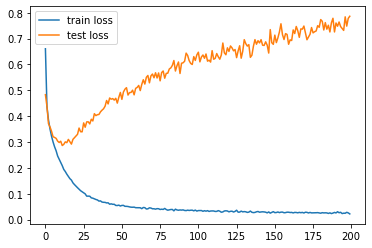

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
#testing

model.eval()
accuracy = []
for index , (img , label) in enumerate(test_loader):
    img, label = img.to(device) , label.to(device)
    output = model.forward(img)
    _ , max_indices = torch.max(output,1)
    test_acc = np.mean(np.round(label.detach().cpu().numpy()) == np.round(max_indices.detach().cpu().numpy()))
    accuracy.append(test_acc)
np.mean(accuracy)

0.9037776898734177

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[861   2  19  21   2   1  89   0   5   0]
 [  2 977   2  11   2   0   5   0   1   0]
 [ 22   1 870  10  53   0  42   0   2   0]
 [ 13   8  13 911  30   1  22   0   1   1]
 [  2   1  45  23 861   0  63   0   5   0]
 [  1   0   0   1   0 977   0  15   0   6]
 [114   0  70  25  92   0 690   0   9   0]
 [  0   0   0   0   0  13   0 965   0  22]
 [  5   1   5   0   5   3   5   4 972   0]
 [  1   0   0   0   0   6   0  35   1 957]]


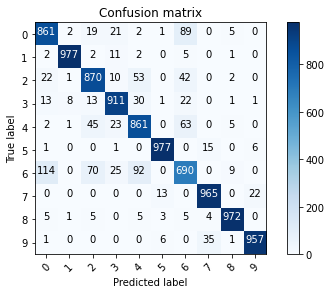

In [ ]:
x_test = fmnist_test.data.numpy()
y_test = fmnist_test.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))